In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from scipy import signal

from processing_helpers import get_energy
from processing_helpers import get_con_energy
from processing_helpers import get_residuals


In [2]:
joule_to_uWh = 0.000277777778*1000*1000

In [3]:
coap_256_nb    = pd.read_csv("../measurements/otii/model_test_coap_256_nb.csv"   , usecols = ["Arc Main Energy (J)"]).to_numpy()*joule_to_uWh
coap_256_ltem  = pd.read_csv("../measurements/otii/model_test_coap_256_ltem.csv" , usecols = ["Arc Main Energy (J)"]).to_numpy()*joule_to_uWh
coap_1280_nb   = pd.read_csv("../measurements/otii/model_test_coap_1280_nb.csv"  , usecols = ["Arc Main Energy (J)"]).to_numpy()*joule_to_uWh
coap_1280_ltem = pd.read_csv("../measurements/otii/model_test_coap_1280_ltem.csv", usecols = ["Arc Main Energy (J)"]).to_numpy()*joule_to_uWh

mqtt_256_nb    = pd.read_csv("../measurements/otii/model_test_mqtt_256_nb.csv"   , usecols = ["Arc Main Energy (J)"]).to_numpy()*joule_to_uWh
mqtt_256_ltem  = pd.read_csv("../measurements/otii/model_test_mqtt_256_ltem.csv" , usecols = ["Arc Main Energy (J)"]).to_numpy()*joule_to_uWh
mqtt_4096_nb   = pd.read_csv("../measurements/otii/model_test_mqtt_4096_nb.csv"  , usecols = ["Arc Main Energy (J)"]).to_numpy()*joule_to_uWh
mqtt_4096_ltem = pd.read_csv("../measurements/otii/model_test_mqtt_4096_ltem.csv", usecols = ["Arc Main Energy (J)"]).to_numpy()*joule_to_uWh

In [4]:
regression_results = pd.read_csv("reg_res.csv")

timing_coap_nb = regression_results["timing_coap_nb"].to_numpy()
energy_coap_nb = regression_results["energy_coap_nb"].to_numpy()
timing_coap_ltem = regression_results["timing_coap_ltem"].to_numpy()
energy_coap_ltem = regression_results["energy_coap_ltem"].to_numpy()
timing_mqtt_nb = regression_results["timing_mqtt_nb"].to_numpy()
energy_mqtt_nb = regression_results["energy_mqtt_nb"].to_numpy()
timing_mqtt_ltem = regression_results["timing_mqtt_ltem"].to_numpy()
energy_mqtt_ltem = regression_results["energy_mqtt_ltem"].to_numpy()


In [5]:
V = 3.7

f_micro = 1/(1000*1000)
hour = 3600

sample_pagings_act = [2.49, 2.50, 2.48, 2.45,2.50]
sample_pagings_con = [2.39, 2.33, 2.83, 2.36, 2.84, 2.42, 2.34, 2.82, 2.38]
print(np.mean(sample_pagings_con))

sample_con_end = [7.32, 8.25, 7.54, 8.03, 7.61]

2.523333333333333


In [6]:
#device parameters
p_idle = 155*V #W
p_sleep = 108*V #W


In [7]:
start_mqtt_nb   = [37,137] #[time,energy]
start_mqtt_ltem = [20,265]
start_coap_nb   = [33,110]
start_coap_ltem = [15,201]



In [8]:
## Con_energy : (cDRX timeout, paging interval, paging energy, disconnect energy)

#NB-IoT
E_cdrx_nb = get_con_energy(
    t_inactive   = 20.48,
    t_cycle      = 2.048,
    t_onDuration = 0.200,
    E_monitor    = 2.50,
    E_release    = 1.93,
    p_idle  = p_idle)

#LTE-M
E_cdrx_ltem = get_con_energy(
    t_inactive   = 10.24,
    t_cycle      = 0.320, 
    t_onDuration = 0.100,
    E_monitor    = 3.15,
    E_release    = 0.376,
    p_idle  = p_idle
)

E_cdrx_ltem_short = get_con_energy(
    t_inactive   = 2.56,
    t_cycle      = 0.320, 
    t_onDuration = 0.100,
    E_monitor    = 3.15,
    E_release    = 0.376,
    p_idle  = p_idle
)
#Active state variables
t_active = 30 #s
t_act_interval = 2.56 #s

e_act_paging = 2.50 * f_micro #uWh
e_act_end = 0.252 * f_micro
e_act_init_paging = 1.52 * f_micro #uWh




In [9]:
print(E_cdrx_nb)
print(E_cdrx_ltem)
print(E_cdrx_ltem_short)

start_coap_ltem_short = [start_coap_ltem[0]-(10.24-2.56), start_coap_ltem[1]-E_cdrx_ltem+E_cdrx_ltem_short]
print(start_coap_ltem_short)

29.873966666666664
102.29751111111109
25.856377777777773
[7.32, 124.55886666666669]


In [10]:
class Test:
    def __init__(self, data, T_msg, n_bytes, t, E, E_start, cdrx):
        self.data = data
        self.duration = np.linspace(0,len(data)*0.00025,len(data))    
        self.T_msg = T_msg
        self.n_bytes = n_bytes
        self.t = t
        self.E = E
        self.E_start = E_start
        self.cdrx = cdrx

coap_test_array = []
coap_test_array.append(Test(coap_256_nb,    300,256, timing_coap_nb,   energy_coap_nb, start_coap_nb, E_cdrx_nb))
coap_test_array.append(Test(coap_256_ltem,  300,256, timing_coap_ltem, energy_coap_ltem, start_coap_ltem, E_cdrx_ltem))
coap_test_array.append(Test(coap_1280_nb,   300,1280,timing_coap_nb,   energy_coap_nb, start_coap_nb, E_cdrx_nb))
coap_test_array.append(Test(coap_1280_ltem, 300,1280,timing_coap_ltem, energy_coap_ltem, start_coap_ltem, E_cdrx_ltem))


mqtt_test_array = []
mqtt_test_array.append(Test(mqtt_256_nb,    300,256,  timing_mqtt_nb,   energy_mqtt_nb,   start_mqtt_nb, E_cdrx_nb))
mqtt_test_array.append(Test(mqtt_256_ltem,  300,256,  timing_mqtt_ltem, energy_mqtt_ltem, start_mqtt_ltem, E_cdrx_ltem))
mqtt_test_array.append(Test(mqtt_4096_nb,   300,4096, timing_mqtt_nb,   energy_mqtt_nb,   start_mqtt_nb, E_cdrx_nb))
mqtt_test_array.append(Test(mqtt_4096_ltem, 300,4096, timing_mqtt_ltem, energy_mqtt_ltem, start_mqtt_ltem, E_cdrx_ltem))


In [11]:
coap_predictions = []

for i in coap_test_array:
    coap_predictions.append( 
        get_energy(
            n_bytes = i.n_bytes, 
            max_bytes = 1439, 
            T_msg = i.T_msg,
            E_cdrx = i.cdrx,
            p_sleep = p_sleep,
            reg_coeffs_t = i.t,
            reg_coeffs_e = i.E,
            start_params = i.E_start
        )
    )

mqtt_predictions = []
for i in mqtt_test_array:
    mqtt_predictions.append( 
        get_energy(
            n_bytes = i.n_bytes, 
            max_bytes = 4096, 
            T_msg = i.T_msg,
            E_cdrx = i.cdrx,
            p_sleep = p_sleep,
            reg_coeffs_t = i.t,
            reg_coeffs_e = i.E,
            start_params = i.E_start
        )
    )

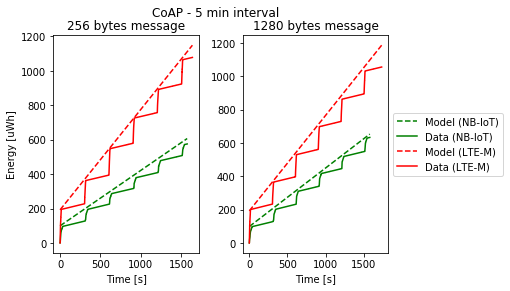

In [12]:
fig, (ax1, ax2) = plt.subplots(1,2)
plt.subplots_adjust(wspace = 0.3)

fig.suptitle("CoAP - 5 min interval")

ax1.set_ylabel("Energy [uWh]")
ax1.set_xlabel("Time [s]")
ax2.set_xlabel("Time [s]")

ax1.set_title("256 bytes message")
ax2.set_title("1280 bytes message")

style = [["g--" , "g"],["r--","r"]]
labels = [["Model (NB-IoT)", "Data (NB-IoT)"], ["Model (LTE-M)", "Data (LTE-M)"]]


for i in range(2):
    curr_durr = coap_test_array[i].duration
    ax1.plot(curr_durr, coap_predictions[i][0]*curr_durr + coap_predictions[i][1], style[i][0])
    ax1.plot(curr_durr, coap_test_array[i].data, style[i][1])

for i in range(2,4):
    curr_durr = coap_test_array[i].duration
    ax2.plot(curr_durr, coap_predictions[i][0]*curr_durr + coap_predictions[i][1], style[i-2][0], label = labels[i-2][0])
    ax2.plot(curr_durr, coap_test_array[i].data, style[i-2][1], label = labels[i-2][1])

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))


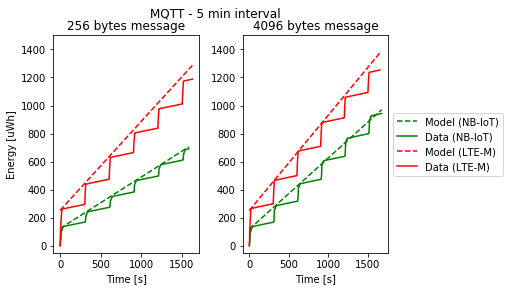

In [13]:
fig, (ax1, ax2) = plt.subplots(1,2)

plt.subplots_adjust(wspace = 0.3)

fig.suptitle("MQTT - 5 min interval")

y_min = -50
y_max = 1500

ax1.set_ylim([y_min,y_max])
ax2.set_ylim([y_min,y_max])

ax1.set_ylabel("Energy [uWh]")
ax1.set_xlabel("Time [s]")
ax2.set_xlabel("Time [s]")

ax1.set_title("256 bytes message")
ax2.set_title("4096 bytes message")

style = [["g--" , "g"],["r--","r"]]
labels = [["Model (NB-IoT)", "Data (NB-IoT)"], ["Model (LTE-M)", "Data (LTE-M)"]]

for i in range(2):
    curr_dur = mqtt_test_array[i].duration
    ax1.plot(curr_dur, mqtt_predictions[i][0]*curr_dur + mqtt_predictions[i][1], style[i][0])
    ax1.plot(curr_dur, mqtt_test_array[i].data, style[i][1])

for i in range(2,4):
    curr_dur = mqtt_test_array[i].duration
    ax2.plot(curr_dur, mqtt_predictions[i][0]*curr_dur + mqtt_predictions[i][1], style[i-2][0], label = labels[i-2][0])
    ax2.plot(curr_dur, mqtt_test_array[i].data, style[i-2][1], label = labels[i-2][1])

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [14]:
def get_msg_idxs(test_data):
    
    test_msg_idxs = []

    diff_array = np.diff(test_data, axis=0)
    i = len(diff_array)-1

    while(i > 0):
        curr_diff = diff_array[i]
        if (curr_diff > 0.010):
            test_msg_idxs.append(i)
            i-=960000
        else:
            i-=1
    test_msg_idxs.reverse()
    return test_msg_idxs

In [15]:
idx = 0
test_tuples_coap = []

for i in coap_test_array:
    test_msg_idxs = get_msg_idxs(i.data)
    
    msg_energy_tuples = []

    for x in test_msg_idxs:
        #new_tuple = ()
        msg_energy_tuples.append(
            i.data[x]-(coap_predictions[idx][0]*x*0.00025 + coap_predictions[idx][1]))
    idx += 1
    test_tuples_coap.append(msg_energy_tuples)



In [16]:
idx = 0
test_tuples_mqtt = []

for i in mqtt_test_array:
    test_msg_idxs = get_msg_idxs(i.data)
    
    msg_energy_tuples = []

    for x in test_msg_idxs:
        #new_tuple = ()
        msg_energy_tuples.append(
            i.data[x]-(mqtt_predictions[idx][0]*x*0.00025 + mqtt_predictions[idx][1]))
    idx += 1
    test_tuples_mqtt.append(msg_energy_tuples)

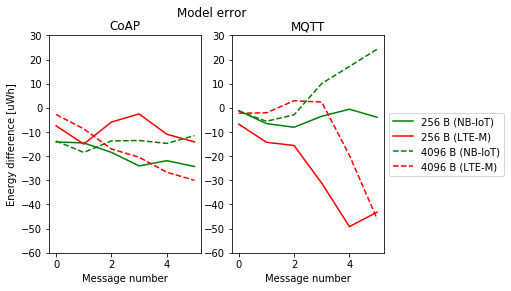

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2)

fig.suptitle("Model error")

ax1.set_title("CoAP")
ax2.set_title("MQTT")

ax1.set_ylabel("Energy difference [uWh]")
ax1.set_xlabel("Message number")
ax2.set_xlabel("Message number")

y_min = -60
y_max = 30

ax1.set_ylim([y_min,y_max])
ax2.set_ylim([y_min,y_max])

labels = ["256 B (NB-IoT)", "256 B (LTE-M)", "4096 B (NB-IoT)", "4096 B (LTE-M)",]
styles = ["g","r","g--","r--"]

for i in range(len(test_tuples_coap)):
    ax1.plot(test_tuples_coap[i], styles[i])
    ax2.plot(test_tuples_mqtt[i], styles[i], label = labels[i])

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

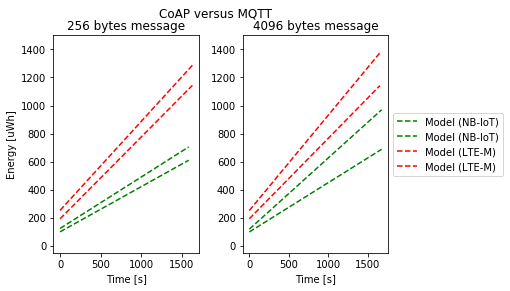

In [18]:
fig, (ax1, ax2) = plt.subplots(1,2)

plt.subplots_adjust(wspace = 0.3)

fig.suptitle("CoAP versus MQTT")

y_min = -50
y_max = 1500

ax1.set_ylim([y_min,y_max])
ax2.set_ylim([y_min,y_max])

ax1.set_ylabel("Energy [uWh]")
ax1.set_xlabel("Time [s]")
ax2.set_xlabel("Time [s]")

ax1.set_title("256 bytes message")
ax2.set_title("4096 bytes message")

style = [["g--" , "g"],["r--","r"]]
labels = [["Model (NB-IoT)", "Data (NB-IoT)"], ["Model (LTE-M)", "Data (LTE-M)"]]

for i in range(2):
    curr_dur = mqtt_test_array[i].duration
    ax1.plot(curr_dur, mqtt_predictions[i][0]*curr_dur + mqtt_predictions[i][1], style[i][0])
    ax1.plot(curr_dur, coap_predictions[i][0]*curr_dur + coap_predictions[i][1], style[i][0])

for i in range(2,4):
    curr_dur = mqtt_test_array[i].duration
    ax2.plot(curr_dur, mqtt_predictions[i][0]*curr_dur + mqtt_predictions[i][1], style[i-2][0], label = labels[i-2][0])
    ax2.plot(curr_dur, coap_predictions[i][0]*curr_dur + coap_predictions[i][1], style[i-2][0], label = labels[i-2][0])

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [29]:
coap_ltem_small   = Test(coap_256_ltem,  300,256, timing_coap_ltem, energy_coap_ltem, start_coap_ltem_short, E_cdrx_ltem_short)
coap_ltem_large   = Test(coap_1280_ltem, 300,1280,timing_coap_ltem, energy_coap_ltem, start_coap_ltem_short, E_cdrx_ltem_short)
coap_nb_small     = Test(coap_256_nb,    300,256, timing_coap_nb,   energy_coap_nb, start_coap_nb, E_cdrx_nb)
coap_nb_large     = Test(coap_1280_nb,   300,1280,timing_coap_nb,   energy_coap_nb, start_coap_nb, E_cdrx_nb)

endpoint = 1000

coap_ltem_small_energy = get_energy(
        n_bytes      = coap_ltem_small.n_bytes, 
        max_bytes    = 1439, 
        T_msg        = coap_ltem_small.T_msg,
        E_cdrx       = coap_ltem_small.cdrx,
        p_sleep      = p_sleep,
        reg_coeffs_t = coap_ltem_small.t,
        reg_coeffs_e = coap_ltem_small.E,
        start_params = coap_ltem_small.E_start
)

coap_ltem_large_energy = get_energy(
        n_bytes      = coap_ltem_large.n_bytes, 
        max_bytes    = 1439, 
        T_msg        = coap_ltem_large.T_msg,
        E_cdrx       = coap_ltem_large.cdrx,
        p_sleep      = p_sleep,
        reg_coeffs_t = coap_ltem_large.t,
        reg_coeffs_e = coap_ltem_large.E,
        start_params = coap_ltem_large.E_start
)

coap_nb_small_energy = get_energy(
        n_bytes      = coap_nb_small.n_bytes, 
        max_bytes    = 1439, 
        T_msg        = coap_nb_small.T_msg,
        E_cdrx       = coap_nb_small.cdrx,
        p_sleep      = p_sleep,
        reg_coeffs_t = coap_nb_small.t,
        reg_coeffs_e = coap_nb_small.E,
        start_params = coap_nb_small.E_start
)

coap_nb_large_energy = get_energy(
        n_bytes      = coap_nb_large.n_bytes, 
        max_bytes    = 1439, 
        T_msg        = coap_nb_large.T_msg,
        E_cdrx       = coap_nb_large.cdrx,
        p_sleep      = p_sleep,
        reg_coeffs_t = coap_nb_large.t,
        reg_coeffs_e = coap_nb_large.E,
        start_params = coap_nb_large.E_start
)

t = np.linspace(0,endpoint,int(endpoint/0.00025))


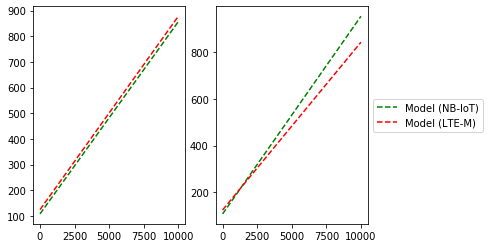

In [30]:
fig, (ax1, ax2) = plt.subplots(1,2)

ax1.plot(t, coap_nb_small_energy[0]*t + coap_nb_small_energy[1],     "g--", label = "Model (NB-IoT)")
ax1.plot(t, coap_ltem_small_energy[0]*t + coap_ltem_small_energy[1],     "r--", label = "Model (LTE-M)")

ax2.plot(t, coap_nb_large_energy[0]*t + coap_nb_large_energy[1],     "g--", label = "Model (NB-IoT)")
ax2.plot(t, coap_ltem_large_energy[0]*t + coap_ltem_large_energy[1],     "r--", label = "Model (LTE-M)")

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [43]:

msg_size_coap = 256
msg_size_mqtt = 256

coap_ltem_lp   = Test(coap_256_ltem,  900,msg_size_coap, timing_coap_ltem, energy_coap_ltem, start_coap_ltem, E_cdrx_ltem)
coap_nb_lp     = Test(coap_256_nb,    900,msg_size_coap, timing_coap_nb,   energy_coap_nb,   start_coap_nb, E_cdrx_nb)


mqtt_ltem_lp   = Test(mqtt_256_ltem, 900, msg_size_mqtt, timing_mqtt_ltem, energy_mqtt_ltem, start_mqtt_ltem, E_cdrx_ltem)
mqtt_nb_lp     = Test(mqtt_256_nb,   900, msg_size_mqtt, timing_mqtt_nb,   energy_mqtt_nb,   start_mqtt_nb,   E_cdrx_nb)

p_sleep_low = 4 #uA

coap_nb_lp_energy = get_energy(
        n_bytes      = coap_nb_lp.n_bytes, 
        max_bytes    = 1439, 
        T_msg        = coap_nb_lp.T_msg,
        E_cdrx       = coap_nb_lp.cdrx,
        p_sleep      = p_sleep_low,
        reg_coeffs_t = coap_nb_lp.t,
        reg_coeffs_e = coap_nb_lp.E,
        start_params = coap_nb_lp.E_start
)

coap_ltem_lp_energy = get_energy(
        n_bytes      = coap_ltem_lp.n_bytes, 
        max_bytes    = 1439, 
        T_msg        = coap_ltem_lp.T_msg,
        E_cdrx       = coap_ltem_lp.cdrx,
        p_sleep      = p_sleep_low,
        reg_coeffs_t = coap_ltem_lp.t,
        reg_coeffs_e = coap_ltem_lp.E,
        start_params = coap_ltem_lp.E_start
)

mqtt_nb_lp_energy = get_energy(
        n_bytes      = mqtt_nb_lp.n_bytes, 
        max_bytes    = 4096, 
        T_msg        = mqtt_nb_lp.T_msg,
        E_cdrx       = mqtt_nb_lp.cdrx,
        p_sleep      = p_sleep_low,
        reg_coeffs_t = mqtt_nb_lp.t,
        reg_coeffs_e = mqtt_nb_lp.E,
        start_params = mqtt_nb_lp.E_start
)

mqtt_ltem_lp_energy = get_energy(
        n_bytes      = mqtt_ltem_lp.n_bytes, 
        max_bytes    = 4096, 
        T_msg        = mqtt_ltem_lp.T_msg,
        E_cdrx       = mqtt_ltem_lp.cdrx,
        p_sleep      = p_sleep_low,
        reg_coeffs_t = mqtt_ltem_lp.t,
        reg_coeffs_e = mqtt_ltem_lp.E,
        start_params = mqtt_ltem_lp.E_start
)

capacity = 37000000 #ah
coap_lp_nb_time   = (capacity - coap_nb_lp_energy[1])/coap_nb_lp_energy[0]
coap_lp_ltem_time = (capacity - coap_ltem_lp_energy[1])/coap_ltem_lp_energy[0]

mqtt_lp_nb_time   = (capacity - mqtt_nb_lp_energy[1])/mqtt_nb_lp_energy[0]
mqtt_lp_ltem_time = (capacity - mqtt_ltem_lp_energy[1])/mqtt_ltem_lp_energy[0]

print("CoAP NB-IoT: " + str(coap_lp_nb_time/3600/24/365))
print("CoAP LTE-M: " +  str(coap_lp_ltem_time/3600/24/365))

print("MQTT NB-IoT: " + str(mqtt_lp_nb_time/3600/24/365))
print("MQTT LTE-M: " +  str(mqtt_lp_ltem_time/3600/24/365))



CoAP NB-IoT: 15.652502566682056
CoAP LTE-M: 7.317464693448733
MQTT NB-IoT: 13.032172356156375
MQTT LTE-M: 6.609201775627524


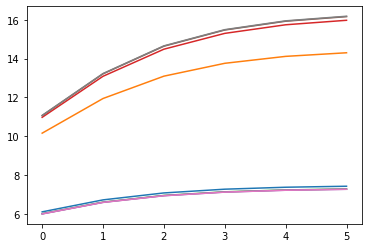

In [53]:
energy_test_array = [4,8,16,32,64,128]
energy_test_array.reverse()
msg_size_test_array = [1,10,100,1000]
msg_size_test_array.reverse()

coap_test_times = []

#CoAP
for i in msg_size_test_array:
    test_time_nb = []
    test_time_ltem = []
    curr_ltem_test = Test(coap_256_nb, 900,i, timing_coap_ltem, energy_coap_ltem, start_coap_ltem_short, E_cdrx_ltem_short)
    curr_nb_test =   Test(coap_256_nb, 900,i, timing_coap_nb, energy_coap_nb,     start_coap_nb, E_cdrx_nb)
    for j in energy_test_array:
        curr_ltem_energy = get_energy(
            n_bytes      = curr_ltem_test.n_bytes, 
            max_bytes    = 1439, 
            T_msg        = curr_ltem_test.T_msg,
            E_cdrx       = curr_ltem_test.cdrx,
            p_sleep      = j,
            reg_coeffs_t = curr_ltem_test.t,
            reg_coeffs_e = curr_ltem_test.E,
            start_params = curr_ltem_test.E_start
        )

        curr_nb_energy = get_energy(
            n_bytes      = curr_nb_test.n_bytes, 
            max_bytes    = 1439, 
            T_msg        = curr_nb_test.T_msg,
            E_cdrx       = curr_nb_test.cdrx,
            p_sleep      = j,
            reg_coeffs_t = curr_nb_test.t,
            reg_coeffs_e = curr_nb_test.E,
            start_params = curr_nb_test.E_start
        )

        test_time_ltem.append(((capacity - curr_ltem_energy[1])/curr_ltem_energy[0])/3600/24/365)
        test_time_nb.append(((capacity - curr_nb_energy[1])/curr_nb_energy[0])/3600/24/365)

    coap_test_times.append(test_time_ltem)
    coap_test_times.append(test_time_nb)

for i in coap_test_times:
    plt.plot(i)